# Homework 2 - Soccer analytics

### Libraries

In [1]:
import pandas as pd

# for the chi-squared test
from scipy.stats import chi2_contingency

# for the plots
import matplotlib.pyplot as plt
import matplotlib

# [RQ1] Who wants to be a Champion?
#### Tasks:
1. Create a plot where each point (x,y) represents the number of points obtained by team x at game week y.
2. Highlight the two teams that got the longest winning streak and the two teams that got the longest losing streak.

### Datasets
In order to solve the question we need infos concerning only matches and teams. Let's take a look at the datasets.

In [2]:
matches = pd.read_json("matches_England.json")
teams = pd.read_json("teams.json")

In [3]:
matches.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089
1,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",Selhurst Park,1628,2500090
2,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",The John Smith's Stadium,1609,2500091
3,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",Anfield,1612,2500092
4,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",Old Trafford,1611,2500093


In [4]:
teams.head()

,area,city,name,officialName,type,wyId
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",Newcastle upon Tyne,Newcastle United,Newcastle United FC,club,1613
1,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Vigo,Celta de Vigo,Real Club Celta de Vigo,club,692
2,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Barcelona,Espanyol,Reial Club Deportiu Espanyol,club,691
3,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Vitoria-Gasteiz,Deportivo Alav\u00e9s,Deportivo Alav\u00e9s,club,696
4,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",Valencia,Levante,Levante UD,club,695


### Cleaning and setting the data
We drop the columns not needed of the datasets matches and teams.

The teams will be also filtered depending on their area, because we're going to use the list of English teams to build the final DataFrame to plot.

In [5]:
# from matches we need only the columns 'gameweek' (to sort the cumulative points later),
# 'teamsData' (to understand to which teams the game infos relate) and 'winner' (to assign the points later)
matches.drop(columns=['competitionId','date','duration','wyId','dateutc',
                      'label','referees','roundId','seasonId','status','venue'],
            inplace=True)

In [6]:
# from teams we need to build a dictionary of the teams playing in the English Championship only
# so that we'll be able to find the team name corresponding through its 'wyId'.
notEng = []
for i in range(len(teams)):
    if (teams.loc[i,'area']['alpha3code'] != 'XEN' and teams.loc[i,'area']['alpha3code'] != 'XWA') or teams.loc[i,'type'] != 'club':
        notEng += [i]
teams.drop(notEng,inplace=True)

teams.index=teams['wyId']
team = pd.Series.to_dict(teams['officialName'])

It is important to sort the rows of the DataFrame 'matches' in order to do the cumulative sum of the points in ascending order based on the weeks.

In [7]:
matches.sort_values('gameweek', inplace=True)

### Creating the table (English team)x(game week)
The entries we're going to put in the table are the points cumulated by each team in every game week.

In [8]:
num_weeks = matches['gameweek'].max()
gameweeks = list(range(1, num_weeks+1))
result = pd.DataFrame(index=teams['officialName'], columns=gameweeks)

In [9]:
length = len(matches)
for i in range(length):
    g_week = matches.loc[i,'gameweek']
    id1,id2 = list(map(int,matches.loc[i,'teamsData'].keys()))
    if not matches.loc[i,'winner']:
        result.loc[team[id1], g_week] = result.loc[team[id2], g_week] = 1
    elif matches.loc[i,'winner'] == id1:
        result.loc[team[id1], g_week] = 3
        result.loc[team[id2], g_week] = 0
    else:
        result.loc[team[id1], g_week] = 0
        result.loc[team[id2], g_week] = 3

In [10]:
result # at this point, we have the points gained per match per team, sorted by time

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
officialName,,,,,,,,,,,,,,,,,,,,,
Newcastle United FC,0,0,3,3,3,0,1,1,3,0,...,0,3,0,3,3,3,0,0,0,3
Huddersfield Town FC,3,3,1,0,1,1,0,0,3,0,...,0,1,0,0,1,3,1,0,1,0
Swansea City AFC,1,0,3,0,1,0,0,3,0,0,...,3,1,0,0,1,1,0,0,0,0
AFC Bournemouth,0,0,0,0,3,0,1,0,3,0,...,1,0,3,1,1,0,0,0,3,3
Brighton & Hove Albion FC,0,0,1,3,0,3,0,1,3,1,...,3,1,0,0,1,0,1,1,3,0
Burnley FC,3,0,1,3,1,1,3,1,0,3,...,3,3,0,3,3,3,1,1,0,0
Leicester City FC,0,3,0,0,1,0,1,1,3,3,...,1,3,3,3,0,0,1,0,0,0
West Ham United FC,0,0,0,3,1,0,3,1,0,1,...,0,0,1,3,1,1,0,0,3,3
Stoke City FC,0,3,1,1,0,0,3,0,0,3,...,1,0,0,0,0,1,1,1,0,3


## Task 1: points cumulated in each game week
The last thing to do is to cumulate the points gained by each team at every single week.

In [11]:
res = result.T.cumsum()

In order to get the legend of the plot sorted from the winner of the Championship to the last classified, we sort the columns of the DataFrame to plot so that the last row values (the final points) are in descending order.

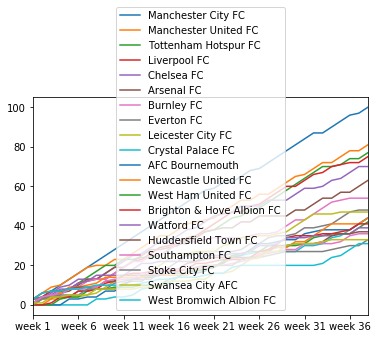

In [12]:
res = res.T.sort_values(num_weeks, ascending=False).T

# last thing: renaming the game week numbers (num) to strings ('week num')
res.index = list(map(lambda a: 'week '+str(a), res.index))

# let's plot!
res.plot()
plt.legend()

## Task 2: longest winning and losing streaks

The idea is to apply a function that can calculate the longest streak of some value (representing a win or a loss) to each team's results.

In order to do this, it is useful to reconsider the DataFrame 'result'.

By applying to (transposed) 'result' a function which returns the longest streak of some value 'VAL' (3 or 0 points) in a vector 'v' (the vector of points sorted by game week), we get the table with the streaks for each team to compare.

In [13]:
result = result.T

In [14]:
def streak(v, VAL):
    max = st = 0
    flag = 0
    # flag=1 means that we've already started to count the elements of a streak 'st'
    # flag=0 means that we're still searching for the first element of a streak 'st'
    
    for x in v:

        if x == VAL:
            
            if flag:
                st += 1
                
            else:
                flag = 1
                st += 1
            
        else:
            flag = 0
            if st > max:
                max = st
            st = 0
            
    return max

In [15]:
wStreak = result.apply(lambda v: streak(v,3))
wStreak.sort_values(ascending=False, inplace=True)
wStreak

officialName
Manchester City FC           18
Tottenham Hotspur FC          7
Manchester United FC          4
Chelsea FC                    4
Liverpool FC                  4
Leicester City FC             4
Arsenal FC                    3
Burnley FC                    3
Newcastle United FC           3
Everton FC                    2
West Bromwich Albion FC       2
West Ham United FC            2
Crystal Palace FC             2
Brighton & Hove Albion FC     2
AFC Bournemouth               2
Swansea City AFC              2
Huddersfield Town FC          2
Watford FC                    2
Stoke City FC                 1
Southampton FC                1
dtype: int64

In [16]:
lStreak = result.apply(lambda v: streak(v,0))
lStreak.sort_values(ascending=False, inplace=True)
lStreak

officialName
West Bromwich Albion FC      8
Crystal Palace FC            7
Huddersfield Town FC         5
Watford FC                   4
Swansea City AFC             4
AFC Bournemouth              4
Stoke City FC                4
Newcastle United FC          4
Everton FC                   3
West Ham United FC           3
Burnley FC                   3
Brighton & Hove Albion FC    3
Southampton FC               3
Arsenal FC                   3
Leicester City FC            2
Chelsea FC                   2
Manchester City FC           1
Manchester United FC         1
Tottenham Hotspur FC         1
Liverpool FC                 1
dtype: int64

#### List of the two teams with the longest winning streak (sorted)

In [17]:
list(wStreak.index[0:2])

['Manchester City FC', 'Tottenham Hotspur FC']

#### List of the two teams with the longest losing streak (sorted)

In [18]:
list(lStreak.index[0:2])

['West Bromwich Albion FC', 'Crystal Palace FC']

# [RQ2] Is there a home-field advantage?
It is generally believed that there is an underlying home field advantage in sport, i.e. an highest probability of winning of the home team. Let's check for this, and see whether the outcome of the game (win, draw, lose) is correlated to the playing side (home or away). For 5 different teams of Premier League, show the contingency table (outcome x side). Therefore, perform an "overall" Chi-squared test in the following way: build a unique contingency table, that contains all the matches in which only one of the 5 teams previously selected is involved, to see whether there is home field advantage. State clearly the tested hypothesis and whether it is accepted or rejected.

In [19]:
matches_England = pd.read_json('matches_England.json', orient='columns') #read Premier League
#matches_England has many variables and there is a variable that the name is teamData that is a unique table in
#to the matches_England and we need it for this question. So we seprate it from matches_England.

user_dict = matches_England['teamsData'].to_dict()
data = pd.DataFrame.from_dict({(i,j):user_dict[i][j]
                           for i in user_dict.keys() 
                           for j in user_dict[i].keys()},
                    orient='index')

#the formation variables is not important for us so we delete it from our data.
del data['formation']
data.head(5)

scoreET  coachId  side  teamId  score  scoreP  hasFormation  scoreHT
0 1646        0     8880  home    1646      1       0             1        1
  1659        0     8934  away    1659      2       0             1        0
1 1627        0        0  away    1627      0       0             1        0
  1628        0     8357  home    1628      2       0             1        0
2 1609        0     7845  away    1609      1       0             1        1

In [20]:
#for calculating the final score we need the score (Score at the end of the match (not counting penalties) and
#the score at the penalty and the score in Extra time. so we sum them together.
data['final score']=data['score']+data['scoreP']+data['scoreET']

data.head()

scoreET  coachId  side  teamId  score  scoreP  hasFormation  scoreHT  \
0 1646        0     8880  home    1646      1       0             1        1   
  1659        0     8934  away    1659      2       0             1        0   
1 1627        0        0  away    1627      0       0             1        0   
  1628        0     8357  home    1628      2       0             1        0   
2 1609        0     7845  away    1609      1       0             1        1   

        final score  
0 1646            1  
  1659            2  
1 1627            0  
  1628            2  
2 1609            1

In [21]:
#now our data is ready for finding the winner and loser of the matches but first of all we need to rearrange the
#index of our table.
data.index=range(len(data['scoreET']))

data.head()

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score
0,0,8880,home,1646,1,0,1,1,1
1,0,8934,away,1659,2,0,1,0,2
2,0,0,away,1627,0,0,1,0,0
3,0,8357,home,1628,2,0,1,0,2
4,0,7845,away,1609,1,0,1,1,1


In [22]:
#So with the following code we compare each pair of teams and define who is winner and who is loser. and if
#match was draw, we showed it too and put them in to new columns which is called result.
for i in range (0,(len(data)-1),2):
    if ((data.iloc[i]['final score'] > data.iloc[i+1]['final score'])==True):
        data.loc[i,'result']='win'
        data.loc[i+1,'result']='lose'
    elif ((data.iloc[i]['final score'] < data.iloc[i+1]['final score'])==True):
        data.loc[i,'result']='lose'
        data.loc[i+1,'result']='win'
    else:
        data.loc[i,'result']='draw'
        data.loc[i+1,'result']='draw'
        
data.head()

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score,result
0,0,8880,home,1646,1,0,1,1,1,lose
1,0,8934,away,1659,2,0,1,0,2,win
2,0,0,away,1627,0,0,1,0,0,lose
3,0,8357,home,1628,2,0,1,0,2,win
4,0,7845,away,1609,1,0,1,1,1,win


In [23]:
#we choose 5 team and write their teamId into a list. and built a subdata1 which is involved some information
#about the specific teams.
list1=[1646,1627,1673,1633,1611]
subdata1=(data.loc[data['teamId'].isin(list1)])
          
subdata1.head(5)

,scoreET,coachId,side,teamId,score,scoreP,hasFormation,scoreHT,final score,result
0,0,8880,home,1646,1,0,1,1,1,lose
2,0,0,away,1627,0,0,1,0,0,lose
5,0,18572,home,1673,0,0,1,0,0,lose
8,0,3295,home,1611,1,0,1,1,1,win
19,0,8235,home,1633,3,0,1,1,3,win


In [24]:
#with these code we built a dictionary which has data about the number of wins, losses and draws in home or away
#for those specific teams.
d = {}
for p in list1:
    d[p]={'home':[(len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'win')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'lose')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'home') & (subdata1.result == 'draw')]))],
          'away':[(len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'win')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'lose')])),
          (len(subdata1[(subdata1.teamId == p) & (subdata1.side == 'away') & (subdata1.result == 'draw')]))]}
d

{1646: {'home': [7, 7, 5], 'away': [7, 5, 7]},
 1627: {'home': [3, 7, 9], 'away': [3, 12, 4]},
 1673: {'home': [6, 8, 5], 'away': [3, 11, 5]},
 1633: {'home': [7, 6, 6], 'away': [3, 10, 6]},
 1611: {'home': [15, 2, 2], 'away': [10, 5, 4]}}

In [25]:
#built 5 dataframe for each team. in another word, we sperate each team of d dictionary into a dataframe
df1646=pd.DataFrame(data=d[1646],index=['wins','losses','draws'])
df1627=pd.DataFrame(data=d[1627],index=['wins','losses','draws'])
df1673=pd.DataFrame(data=d[1673],index=['wins','losses','draws'])
df1633=pd.DataFrame(data=d[1633],index=['wins','losses','draws'])
df1611=pd.DataFrame(data=d[1611],index=['wins','losses','draws'])

print (df1646.T)
print (df1627.T)
print (df1673.T)
print (df1633.T)
print (df1611.T)

      wins  losses  draws
home     7       7      5
away     7       5      7
      wins  losses  draws
home     3       7      9
away     3      12      4
      wins  losses  draws
home     6       8      5
away     3      11      5
      wins  losses  draws
home     7       6      6
away     3      10      6
      wins  losses  draws
home    15       2      2
away    10       5      4


In [26]:
#with following code we could find chi-squared and p-value
re=chi2_contingency(df1611)
print('the chi-squared is',re[0],'and the p-value is',re[1])

the chi-squared is 2.9523809523809526 and the p-value is 0.22850653346991975


# [RQ4] Who are the top 10 players with the highest ratio between completed passes and attempted passes?

### Datasets

In [27]:
players = pd.read_json('players.json')
teams = pd.read_json('teams.json')
events = pd.read_json('events_England.json')

### Cleaning data

In [28]:
# we need only passes for this task, so we filter the events as follows
passes = events[events['eventName']=='Pass']

# we select only the relevant columns:
# 'playerId' is necessary to attribute a single pass to the player who did it
# 'tags' are necessary to distinguish completed passes
passes = passes[['playerId','tags']]

# from 'players' dataset we create a dictionary of players with wyIds as keys
# this is useful to translate a player id into his name, so that the result will be human-friendly
players.index = players['wyId']
players['Name'] = players['firstName'] + ' ' + players['lastName']
players = players[['Name']]
pl_dict = pd.Series.to_dict(players['Name'])

In the column 'tags' there are a few dictionaries and only one of them can store the tag '1801' which tells us that the pass was completed. In order to make the data clearer, we define a function which can change an entry of this column to 1 if '1801' is found and 0 otherwise. Then, we apply it to the column's cells.

In [29]:
def myFind(L, x):
    for i in L:
        if i['id'] == x:
            return 1
    return 0

passes['tags'] = list(map(lambda a: myFind(a, 1801), list(passes['tags'])))

# now the column 'tags' indicates whether the pass was completed or not, so we change its name for clarity
passes.columns=['playerId','completed passes']

### Counting total and completed passes

In order to count the total number of passes attempted by each player, it is sufficient to calculate the number of rows in which each player compares:

In [30]:
passes_per_player = passes.groupby('playerId').apply(len)
passes_per_player.head()

playerId
0        6
36     898
38     224
48    2370
54    2196
dtype: int64

Instead, in order to count how many passes each player has completed, we can count how many 1s are in the column 'completed passes' for each player:

In [31]:
result = passes.groupby('playerId').sum()
result['passes'] = passes_per_player
result.head()

,completed passes,passes
playerId,,
0,0,6
36,790,898
38,192,224
48,2113,2370
54,1803,2196


### Calculating the ratio (completed passes)/(total passes)

In [32]:
def div_lists(a, b):
    res = []
    l = len(a)
    for i in range(l):
        res += [ a[i]/b[i] ]
    return res

result['ratio'] = div_lists(list(result['completed passes']), list(result['passes']))

# sort the players in ascending ordered based on the ratio
result.sort_values(['ratio'],ascending=False,inplace=True)
result.head(10)

,completed passes,passes,ratio
playerId,,,
532949,1,1,1.0
447538,1,1,1.0
447254,4,4,1.0
423162,18,18,1.0
415747,6,6,1.0
353241,4,4,1.0
340476,1,1,1.0
291528,7,7,1.0
227756,4,4,1.0


### Setting the threshold of minimum passes
This is important not to give insignificant statistics.

An easy way to set it is to take the average number of total passes per player.

In [33]:
minimum = passes_per_player.mean()
minimum

639.4105058365759

In [34]:
# filter the data with the threshold chosen
result = result[result['passes'] > minimum]

### Assigning the name corresponding the playerIds

In [35]:
result['playerName'] = list(map(lambda id: pl_dict[id], list(result.index)))

# show the names of the first ten players with the best ratio (filtering with respect to the threshold)
result[['playerName']].head(10)

,playerName
playerId,
9380,John Stones
8464,Fabian Delph
8307,Vincent Kompany
135103,Andreas Christensen
7918,Phil Jones
70086,Nicol\u00e1s Hern\u00e1n Otamendi
120339,Mohamed Naser Elsayed Elneny
14808,\u0130lkay G\u00fcndo\u011fan
71703,Victor Nilsson Lindel\u00f6f
